# STAT 628 Report
### Fangfei Lin, Lu Chen, Yezhou Li, Chushi Shi

In [7]:
import pandas as pd
import requests, re
import pandas as pd
import seaborn as sns
import numpy as np
import nltk
import string, itertools
import matplotlib.pyplot as plt
from nltk.text import Text
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize, WhitespaceTokenizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
review = pd.read_csv("review_tor_restaurant.csv") 
business = pd.read_csv("asian_restaurant.csv")

### Background

The Yelp dataset has both user and business data. There are 3172 Asian restaurants of five categories, Chinese, Japanese, Korean, Thai and Vietnamnese, in the Greater Toronto Area. Our goal is to provide the business insights from both the perspectives of business owners and users, so that business owners are able to improve their business from data-driven decisions. Our analysis will focus on three parts: social network, sentiment analysis and yelp rating prediction. 

### Social Network Analysis

Nowadays, social media becomes a trend. Instagram, Facebook, Snapchat, the social media impact is ubiquitous. By reconstructing and analyzing the social network of Yelp, we aim to serach for target influencers for business in distinct categories. Moreover, connecting with customers is about knowing what they’re thinking and what they want. The first step to improve thie business is to fully understnad customers' behaviours. 

#### Top 100 Users Label
After we have selected the top 100 users, we can assign labels to each of them based on their preference toward various category. We are curious about their taste perference. Thus, we draw a plot of the number of reviews of each user in each category of asian restaurant. The plot is as below. 

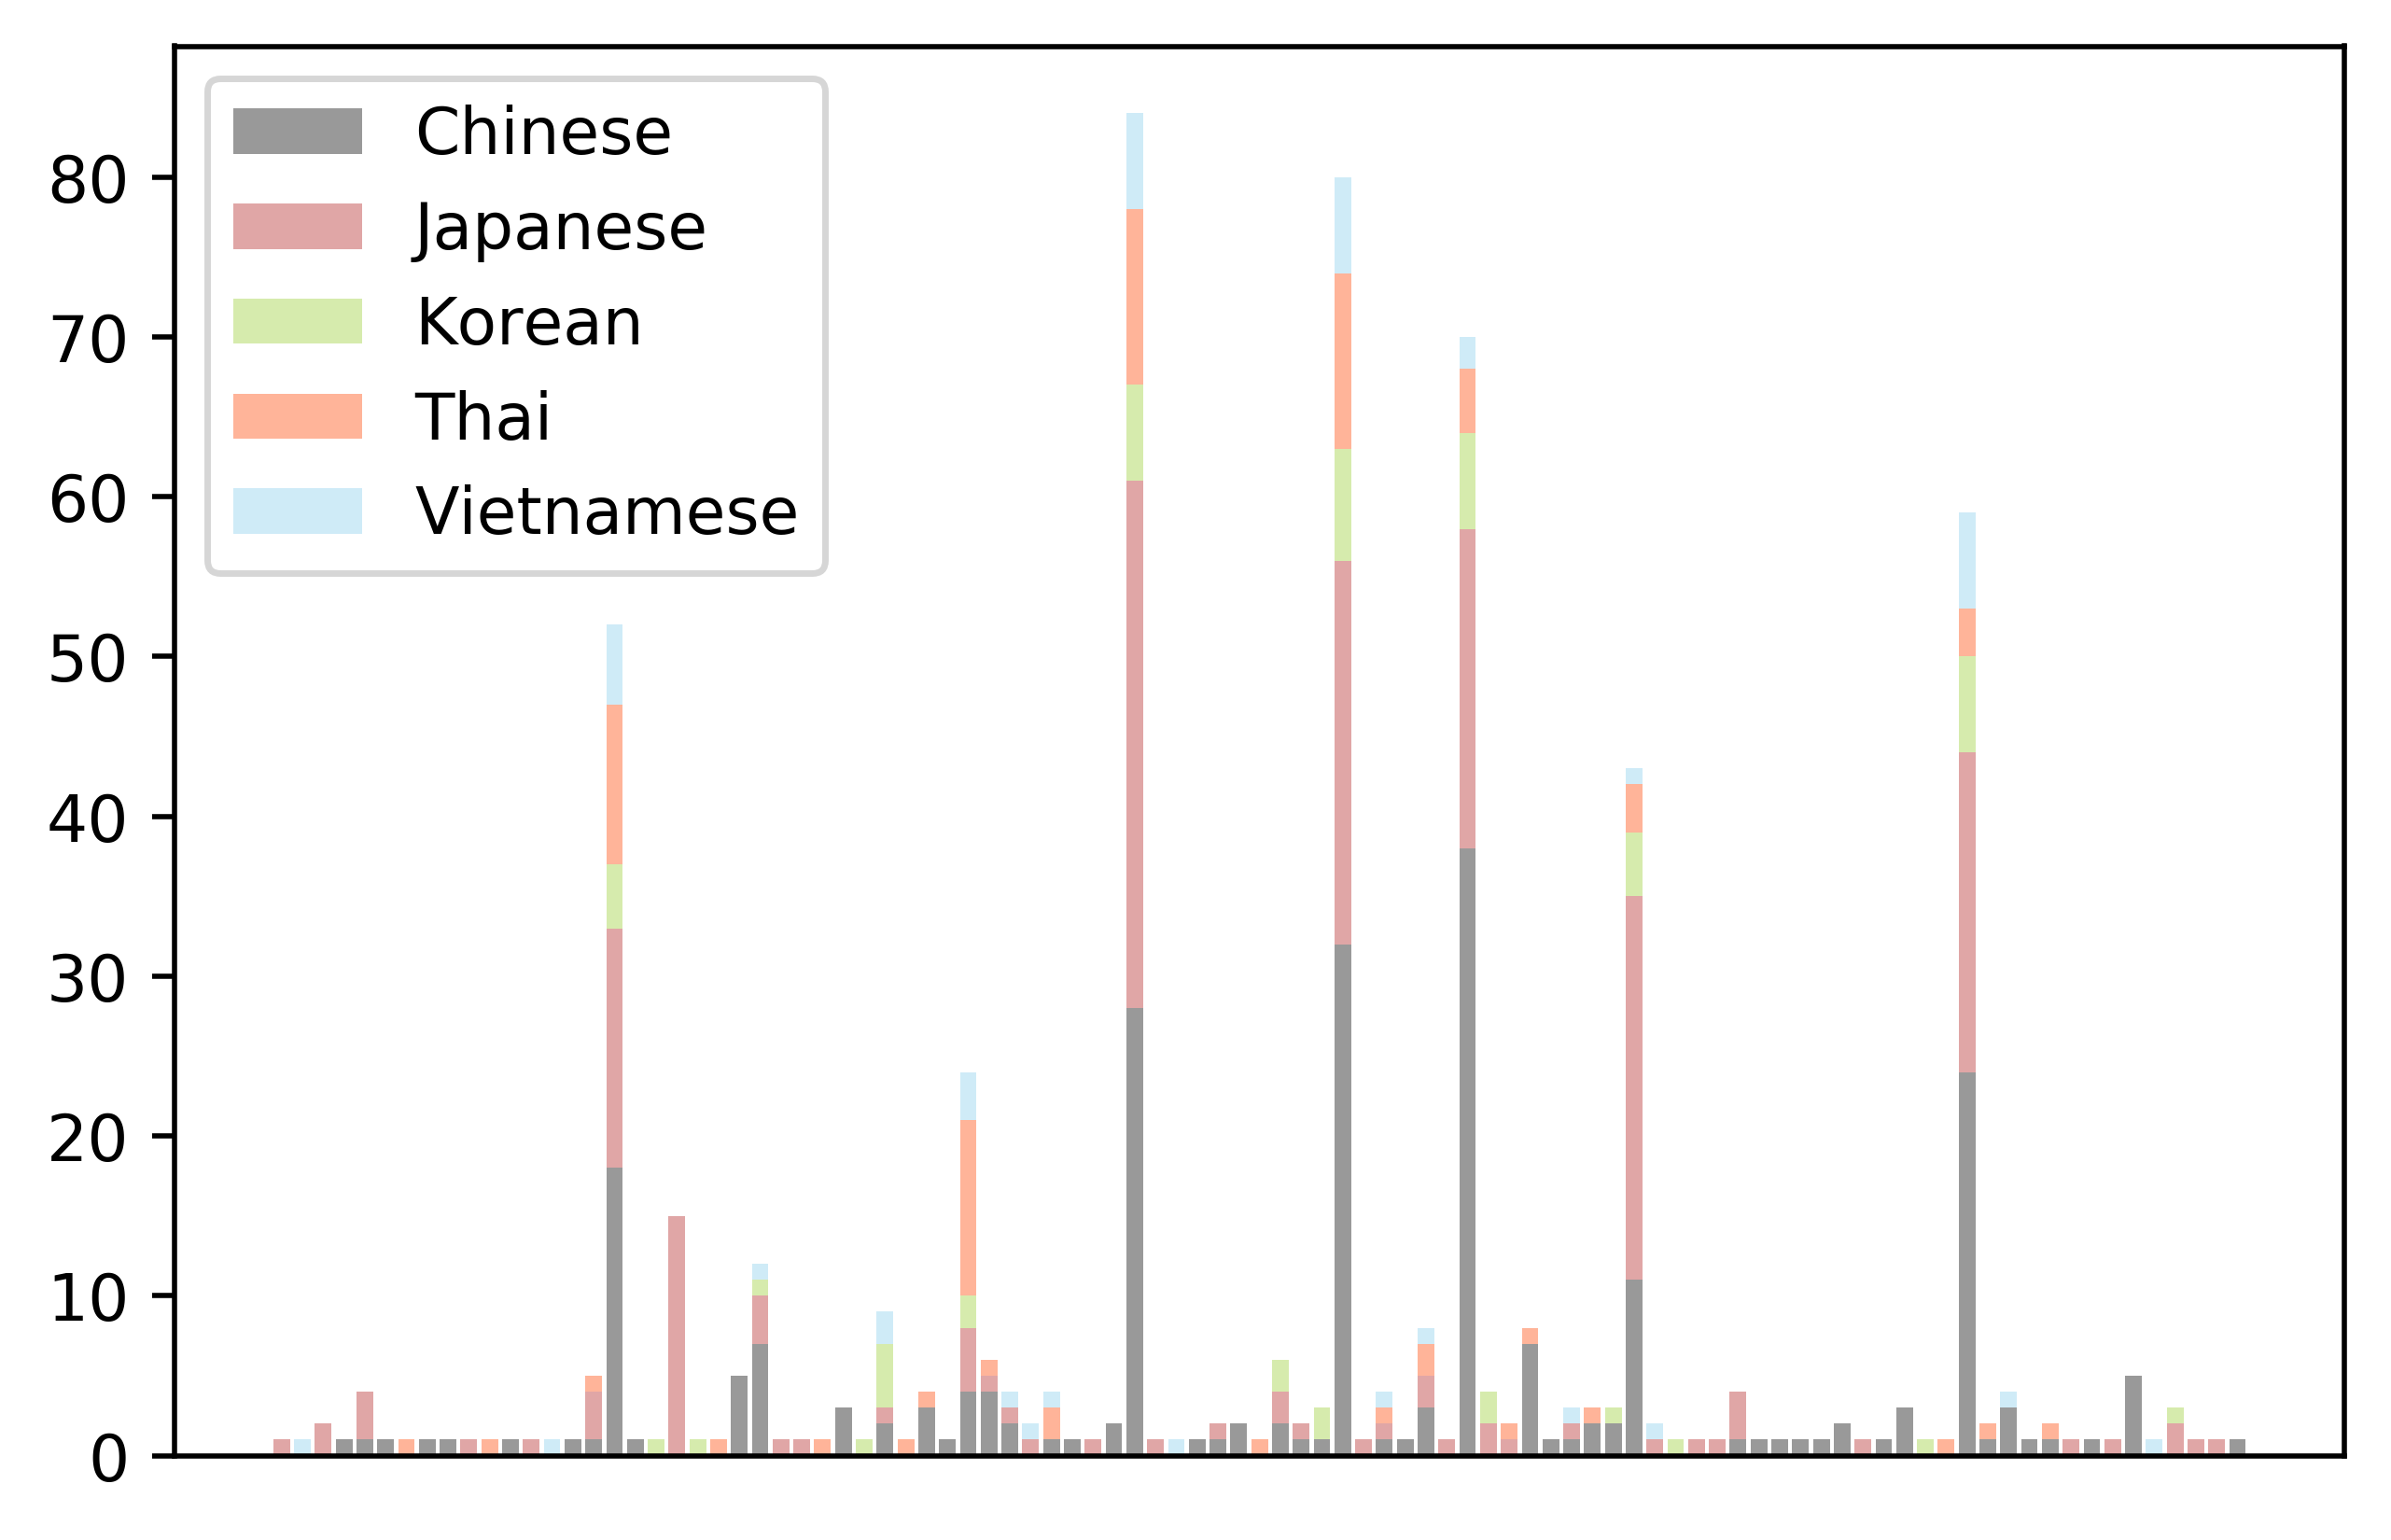

In [18]:
df_category_user = pd.read_csv('df_category_user.csv')
plt.rcParams['savefig.dpi'] = 500 
plt.rcParams['figure.dpi'] = 500 
people = list(df_category_user['user_name'])
x_pos = [i for i, _ in enumerate(people)]
Chinese = np.array(list(df_category_user['Chinese']))
Japanese = np.array(list(df_category_user['Japanese']))
Korean = np.array(list(df_category_user['Korean']))
Thai = np.array(list(df_category_user['Thai']))
Vietnamese = np.array(list(df_category_user['Vietnamese']))
plt.bar(x_pos, Chinese, alpha=0.4, color="black")
plt.bar(x_pos, Japanese,  alpha=0.4, color="firebrick", bottom=Chinese)
plt.bar(x_pos, Korean,  alpha=0.4, color="yellowgreen", bottom=Chinese+Japanese)
plt.bar(x_pos, Thai,  alpha=0.4, color="orangered", bottom=Chinese+Japanese+Korean)
plt.bar(x_pos, Vietnamese,  alpha=0.4, color="skyblue", bottom=Chinese+Japanese+Korean+Thai)
plt.xticks(x_pos, rotation=90)

plt.legend(["Chinese","Japanese","Korean","Thai","Vietnamese"])
plt.xticks([])
plt.show()

In order to help business owners find their target influencers, we label each of the top users, which represents the category of their favorite asian restaurants. By doing so, a business owner can find the most influential users by searching for its restaurant category. These users may do some help if business owners want to do some advertisements to stimulate consumption.

In [6]:
label = pd.read_csv('label.csv')
label.head()

,Unnamed: 0,user_name,user_id,Chineselabel,Japaneselabel,Koreanlabel,Thailabel,Vietnameselabel
0,0,Ryan Gallagher,0GUEuLJVeBVmYJxvkxIPwQ,1,1,1,1,1
1,1,Tracy Swanson,0V4Ra6jCmSAgFtCiORr4QA,1,1,1,1,1
2,2,William Porter,1O638BDK_fWuxgTVJwff-A,1,1,1,1,1
3,3,Michael Bird,2OE7uUsx5VDshFzPFK6XUQ,1,1,1,1,1
4,4,Scott Blevins,2esyx8s04Vrde3Pn8GMNsQ,0,1,0,0,0



### NLP: Sentiment Analysis
In order to gain insights of various types of restaurants, we aim to learn the characteristics of each category from the positive words and negative words in the user's reviews based on each words' polarity score. 

#### Proprocessing the review texts
We remove all the reviews written in foreign language. First, we labeled each review text. If the user rating stars are larger than 4 (including 4 stars), we labeled it as 'positive'; else if the user rating stars are below 3 (including 3 stars), we labeled it as 'negative'. Since the number of reviews above 4 stars and the number of review below 3 stars are balanced. Second, we calculate the number of words in each review, and use this as a feature to train our model. Third, we convert all the letters to lower case and remove all the punctuations. Also, we lemmatize each word. Fourth, I used NLTK stopwords dictionary. Also, I created a stop word list specifically for restaurants reviews, including 'restaurants', 'toronto', 'korean', 'chinese'. By removing all the stop words, we wish increase the accuracy of our model.

#### Calculating the weights of each word
We used bag of words approach to tokenize our review texts. It simply calculated the number of apperance of each word in the review texts. Since each word was treated as an individual feature, our feature matrix would be a high dimensional sparse matrix. By using Linear SVM, it will calculate the weights of each word in the review text in affecting the positivity/negativity of each review. The formula is as below: $$min_{w\in r^{N}}\frac{\lambda}{2}\|w\|^{2}+\frac{1}{m}\sum_{i=1}^{m}max\{0,1-y_{i}w^{T}x_{i}\}$$
$w$ represents the weight of each words, and $x_{i}$ are feature, $y_{i}$ is the labeled class.


#### Calculating the polarity of each word
To explore insights of each category of restaurants, we calculate the polarity of sentiments of each word. The range of polarity is between 0 and 1. Closer to 1 means that the positive sentiment is stronger. Closer to -1 means that the negative sentiments is stronger. The formula is as below: $$Polarity(t,c)=score(t)*\frac{totalfrequency(t,c)}{numberofreviews(c)}$$
where t refers to word, and c refers to category. Total Frequency(t,c) means the number of word t in the reviews of type c restaurants; number of reviews(c) refers to total number of reviews in category c; score t refers to the weight of each word t. 

#### Result: Top words in each category
The top positive and negative words are as below. People explicitly concern more about the taste of food than service. The taste of food directly impact the star ratings of restaurants, since 'delicious','taste' and 'food' are of high rank in both top positive and negative words. In addition, we can tell people's preference and disfavour toward specific dishes and taste in each category. 
![alt text](Positive.png)
![alt text](Negative.png)

In [3]:
#supplemantary functions
def clean_text(text):
    text = re.sub(r'[^A-Za-z ]', '', text)
    text = text.lower()
    return(text)
#This will extract the all the reviews of one specific categor restaurants
def find_category(category):
    df = data[['clean_review','labels']][data.new_category==category]
    df.reset_index(drop=True, inplace =True)
    df.rename(columns={'clean_review':'review'}, inplace=True)
    return df
def split_data(data, test_size):
    train, test = train_test_split(data[['review','labels']],test_size=test_size)
    return train
def filter_words(review):
    lemmatizer = WordNetLemmatizer() 
    stop_list = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", 
 "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 
 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 
 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 
 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 
 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 
 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 
 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 
 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 
 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 
 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 
 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', 
 "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', 
 "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
    my_list = ['try','would','definitely','toronto','highly','made','time','around','also','everything','come'
           ,'comes','really','restaurant','restaurants','im','ive','must','recommend','next','one','always','japanese'
              ,'korean','chinese','vietnamnese','thai','wasnt','person','came','dont','nothing','however','much','end','bit'
              ,'especially','also','always','definitely','highly','around','got','cant','purple','go','get','brought',
              'could','lot','didnt','ordered','used','many']
    #words = [word for word in review.split() if word not in stop_list]
    words = []
    for word in review.split():
        if word not in stop_list+my_list:
            word = lemmatizer.lemmatize(word)
            words.append(word)
    words = ' '.join(words)
    return words

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC

def polarity_score(category):
    reviews_k = find_category(category)
    train, test = train_test_split(reviews_k[['review','labels']],test_size=0.7)
    train.review = train.review.apply(filter_words)
    x_train,y_train=list(train['review']),list(train['labels'])
    x_test,y_test=list(test['review']),list(test['labels'])  
    vectorizer = CountVectorizer()
    feature_train_counts=vectorizer.fit_transform(x_train)
    svm = LinearSVC()
    svm.fit(feature_train_counts, y_train)
    coeff = svm.coef_[0]
    words_score = pd.DataFrame({'score': coeff, 'word': vectorizer.get_feature_names()})
    words_score.set_index('word', inplace=True)
    polarity_score = words_score
    reviews_k = pd.DataFrame(feature_train_counts.toarray(), columns=vectorizer.get_feature_names())
    reviews_k['labels'] = y_train
    frequency = reviews_k[reviews_k['labels'] =='positive'].sum()[:-1]
    polarity_score['frequency'] = frequency
    polarity_score['polarity'] = polarity_score.score * polarity_score.frequency / reviews_k.shape[0]
    pos_mylist = polarity_score.loc[['amazing','love','best','awesome','excellent','good','great',
                                                    'favorite','favourite','loved','perfect','gem','perfectly','wonderful',
                                                    'happy','enjoyed','nice','well','super','like','better','decent','fine',
                                                    'pretty','enough','excited','impressed','ready','fantastic','glad','right',
                                                    'fabulous','every','sure','place','surprised','quite']]
    neg_mylist = polarity_score.loc[['bad','disappointed','unfortunately','disappointing','horrible',
                                                     'lacking','terrible','sorry', 'disappoint','although']]

    polarity_score.drop(pos_mylist.index, axis=0, inplace=True)
    polarity_score.drop(neg_mylist.index, axis=0, inplace=True)
    return(polarity_score)

def plot_top_words(top_words, category):
    plt.figure(figsize=(11,6))
    colors = ['grey' if c < 0 else 'pink' for c in top_words.values]
    sns.barplot(y=top_words.index, x=top_words.values, palette=colors)
    plt.xlabel('Polarity Score', labelpad=10, fontsize=14)
    plt.ylabel('Words', fontsize=14)
    plt.title('Positive and Negative Words in %s Restaurants ' % category, fontsize=15)
    plt.tick_params(labelsize=14)
    plt.xticks(rotation=15)

In [4]:
data = pd.merge(business, review, on = 'business_id')
data.rename(columns={'stars_x':'avg_star','stars_y':'review_star'}, inplace=True)
data['words_count'] = data.text.str.replace('\n',''). \
                                          str.replace('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]','').map(lambda x: len(x.split()))
data['labels'] = ''
data.loc[data.review_star >=4, 'labels'] = 'positive'
data.loc[data.review_star <4, 'labels'] = 'negative'
data['clean_review'] = [clean_text(review) for review in data.text]

#### Example: Thai 

The chart of top ten positive and negative words are shown as below. Top positive words are 'delicious','friendly','curry', 'fresh', 'salad'. From their polarity score, the taste of food always come to the first place and is clearly more important than the service. Some popular dishes are curry and salad. Since there are a lot of fresh fruit and vegetables used in Thai cuisine, the word 'fresh' is not surprising. 


In [5]:
polarity_score_k = polarity_score('Thai')

In [7]:
#Positive
polarity_score_k[polarity_score_k.polarity>0].sort_values('polarity', ascending=False)[:10]

,score,frequency,polarity
word,,,
delicious,0.646394,1098,0.124189
friendly,0.380387,647,0.0430639
curry,0.126946,1790,0.0397607
fresh,0.296449,595,0.0308639
salad,0.166103,630,0.0183106
khao,0.120993,688,0.0145657
make,0.202987,408,0.0144915
new,0.295324,279,0.0144174
packed,0.439906,172,0.0132395


In [6]:
#Negative
polarity_score_k[polarity_score_k.polarity<0].sort_values('polarity', ascending=True)[:10]

,score,frequency,polarity
word,,,
food,-0.076080,3433,-0.0457012
pad,-0.116050,1700,-0.0345205
portions,-0.325669,309,-0.0176084
soup,-0.156183,621,-0.016971
small,-0.239382,352,-0.0147441
see,-0.352785,223,-0.0137657
roll,-0.416159,185,-0.0134715
give,-0.345666,211,-0.0127621
service,-0.058574,1240,-0.012709


In [9]:
positive_words = ['delicious','friendly','curry','fresh','salad','khao']
negative_words = ['food','pad','portions','soup','small','service','atmosphere']
top_words = polarity_score_k.loc[positive_words+negative_words,'polarity']

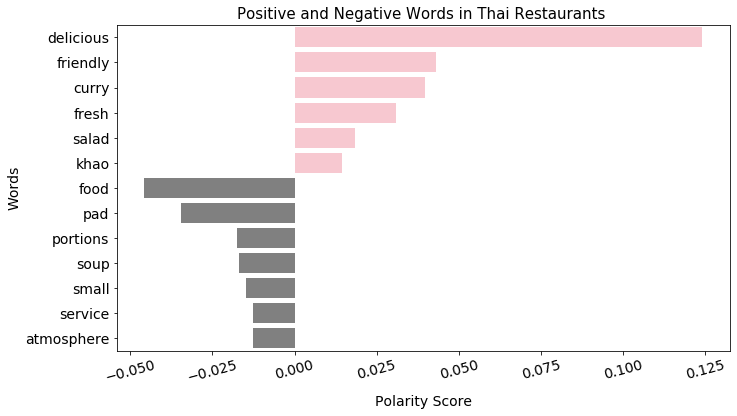

In [12]:
plot_top_words(top_words,'Thai')

Another example would be the Korean restaurants. 

### NLP: Prediction

#### Data Preparation
We first clean the review text by the same tricks used in sentiment analysis. However, instead of bag of words, we use tf-idf to reflect the importance of each words in the review texts. Tf-idf will automatically filter the stop words because of their high frequencies in the review texts. We labeled all the reviews above 4 stars as 'positve', otherwise, we labled them as 'negative'.

#### Model: Naive Bayes Classifier
The accuracy of Naive Bayes is 81%. The accuracy score calculate the proportion of number of correctly predicted positive reviews in total reviews. The precision and recall are 74% and 85%.


In [8]:
review = pd.read_csv("review_tor_restaurant.csv") 
business = pd.read_csv("asian_restaurant.csv") 
review['labels'] = ''
review.loc[review.stars >=4, 'labels'] = 'pos'
review.loc[review.stars <=3, 'labels'] = 'neg'

In [9]:
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score

In [10]:
def clean_text(text):
    lemmatizer = WordNetLemmatizer() 
    text = text.lower()
    text = lemmatizer.lemmatize(text)
    text = re.sub(r'[^A-Za-z ]', '', text)
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    text = [t for t in text if len(t) > 0]
    text = [lemmatizer.lemmatize(word) for word in text]
    text = " ".join(text)
    text = nltk.word_tokenize(text)
    return(text)

review['review_clean'] = review.text.apply(clean_text)

In [11]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(review["review_clean"],review['labels'],test_size=0.3)
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(review["review_clean"].apply(lambda x: np.str_(x)))
Train_X_Tfidf = Tfidf_vect.transform(Train_X.apply(lambda x: np.str_(x)))
Test_X_Tfidf = Tfidf_vect.transform(Test_X.apply(lambda x: np.str_(x)))

In [12]:
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y)*100)

Naive Bayes Accuracy Score ->  81.21051400046798


In [13]:
from sklearn.metrics import f1_score
f1_score(predictions_NB, Test_Y, average=None)

array([0.73722389, 0.85377401])

### Strength and Weakness
Pros:

Cons: 
* In processing the texts, we remove all the reviews in foreign characters. In our analysis, we only focus on five categories of Asian restaurants, indicating that exclusion of foreign language comments may cause strong bias in the result. Based on our personal experience as Asians, we inclined to use our native language to write the reviews. Our analysis is based on the assumption that sentiments of reviews in English are the same as the sentiments of reviews in other language.

* The model and text preprocessing in the prediction are very weak. We should try more models to compare their perfomrances, or improve the accuracy of models by tuning the parametres.

### Reference

Yu bo, Jiaxu Zhou, Yi Zhang, Yunong Cao,(2017) *Identifying Restaurant Features via Sentiment Analysis on Yelp Reviews*

### Contribution
Shiny App: Yezhou Li
Code: Chen Lu (network analysis), Chushi Shi (data cleaning and network analysis), Fangfei Lin (NLP and EDA)